# Dataset exploration

In [42]:
import numpy as np
import numpy.lib.recfunctions as rfn
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import logging

from scipy.stats import mode
from scipy.io import loadmat
from scipy.io.arff import loadarff

import cv2
from pathlib import Path
from tqdm.auto import tqdm

import utils

logging.basicConfig(filename='data/dataset_exploration.log', encoding='utf-8', level=logging.DEBUG)
logger = logging.getLogger(__name__)

## Table of Contents

* [Helper Functions](#helper-functions)
* Datasets
    * [GazeCom](#gazecom)
    * [VidCom](#vidcom)
    * [DHF1K](#dhf1k)
    * [Hollywood-2](#hollywood)
* [Working with Video data](#video-data)
* [Prepare labeling data](#label-data)

<br>
<br>

## Helper Functions <a id='helper-functions' />

In [2]:
def px_to_visual_angle(arr, x_colname, y_colname, width_px, height_px, width, height, dist, x_left_to_right=True, y_top_to_bottom=True):
    '''
    Converts (x,y) pixel values to visual angle values. 
    
    Note: Currently assumes arr is a structured array! (Is the case for GazeCom arff files)
    
    A positive visual angle for the x-axis means the observer is looking to the right.
    A positive visual angle for the y-axis means the observer is looking upwards.
    '''
    x_dist = (arr[x_colname] / width_px - 1/2) * width
    y_dist = -(arr[y_colname] / height_px - 1/2) * height
    
    if not x_left_to_right: x_dist *= -1
    if not y_top_to_bottom: y_dist *= -1
    
    arr_unstruct = rfn.structured_to_unstructured(arr)
    
    x_angle = np.arctan(x_dist / dist)
    y_angle = np.arctan(y_dist / dist)
    
    new_arr_unstruct = np.c_[ arr_unstruct, x_angle ]
    new_arr_unstruct = np.c_[ new_arr_unstruct, y_angle ]

    new_dt = np.dtype(arr.dtype.descr + [('x_angle', '<f8'), ('y_angle', '<f8')])
    
    return np.array(rfn.unstructured_to_structured(new_arr_unstruct), dtype=new_dt) 

In [44]:
# with lbound, ubound comparison (looping)
def avg_over_frames(arr, t_colname, x_colname, y_colname, label_colname, n_frames=None, fps=29.97, f_label=250.):
    '''
    Averages eye tracking results over frames. For EM classification picks the majority vote for an interval.
    
    Note: Currently assumes arr is a structured array! (Is the case for GazeCom arff files)
    '''
    #n_entries_to_frame = len(arr) / n_frames
    n_entries_to_frame = f_label / fps
    
    avg_arr = np.empty((n_frames, 4))
    avg_arr[:, 0] = np.arange(n_frames)   # frame indices
    
    missing_frames = []
    for i in range(n_frames):
        lbound = round(i * n_entries_to_frame)
        ubound = round((i+1) * n_entries_to_frame)
        
        # Check if there is no frame for the label
        if lbound >= len(arr):
            #print(f"No label found for frame {i}.")
            missing_frames.append(i)
            avg_arr[i, 1] = 0
            avg_arr[i, 2] = avg_arr[i-1, 2]
            avg_arr[i, 3] = avg_arr[i-1, 3]
            continue
            
        # take majority for EM classification
        if 2. in arr[label_colname][lbound:ubound]:
            avg_arr[i, 1] = 2
        else:
            avg_arr[i, 1] = mode(arr[label_colname][lbound:ubound])[0]

        # take mean for gaze position
        avg_arr[i, 2] = np.mean(arr[x_colname][lbound:ubound])
        avg_arr[i, 3] = np.mean(arr[y_colname][lbound:ubound]) 
    
    return avg_arr, missing_frames

<br>
<br>

## GazeCom <a id='gazecom' />

In [5]:
dir_arff_ground_truth = r'data/GazeCom/deepEM_classifier/ground_truth'

##### test load an .arff file

In [6]:
sample_path = f'{dir_arff_ground_truth}/beach/AAF_beach.arff'

In [7]:
!head -n 30 'data/GazeCom/deepEM_classifier/ground_truth/beach/AAF_beach.arff'

% Handlabelling data is arranged in 3 columns: handlabeller1 and handlabeller2 indicate the first two experts, handlabeller_final column contains the final, tie-breaking labels.
% Labels in these columns are to be interpreted as follows:
%   - 0 is UNKNOWN
%   - 1 is FIX (fixation)
%   - 2 is SACCADE
%   - 3 is SP (smooth pursuit)
%   - 4 is NOISE
% 
%@METADATA width_px 1280.0
%@METADATA height_px 720.0
%@METADATA width_mm 400.0
%@METADATA height_mm 225.0
%@METADATA distance_mm 450.0
@RELATION gaze_labels

@ATTRIBUTE time INTEGER
@ATTRIBUTE x NUMERIC
@ATTRIBUTE y NUMERIC
@ATTRIBUTE confidence NUMERIC
@ATTRIBUTE handlabeller1 INTEGER
@ATTRIBUTE handlabeller2 INTEGER
@ATTRIBUTE handlabeller_final INTEGER

@DATA
1000,590.9,5.2,1.0,4,4,4
5000,590.9,5.2,1.0,4,4,4
9000,590.6,5.0,1.0,4,4,4
13000,590.4,5.0,1.0,4,4,4
17000,589.8,5.2,1.0,4,4,4
21000,590.0,5.1,1.0,4,4,4


In [8]:
width_px    = 1280.0
height_px   = 720.0
width_mm    = 400.0
height_mm   = 225.0
distance_mm = 450.0

In [9]:
em_mapping = {
    0: 'UNKNOWN/NOISE',
    1: 'FIX',
    2: 'SACCADE',
    3: 'SP',
    4: 'UNKNOWN/NOISE'
}

In [34]:
contents = loadarff(sample_path)
contents

(array([(1.0000e+03, 590.9,   5.2, 1., 4., 4., 4.),
        (5.0000e+03, 590.9,   5.2, 1., 4., 4., 4.),
        (9.0000e+03, 590.6,   5. , 1., 4., 4., 4.), ...,
        (2.0132e+07, 706.7, 670.2, 1., 1., 1., 1.),
        (2.0136e+07, 707.6, 675.2, 1., 1., 1., 1.),
        (2.0140e+07, 708. , 678.6, 1., 1., 1., 1.)],
       dtype=[('time', '<f8'), ('x', '<f8'), ('y', '<f8'), ('confidence', '<f8'), ('handlabeller1', '<f8'), ('handlabeller2', '<f8'), ('handlabeller_final', '<f8')]),
 Dataset: gaze_labels
 	time's type is numeric
 	x's type is numeric
 	y's type is numeric
 	confidence's type is numeric
 	handlabeller1's type is numeric
 	handlabeller2's type is numeric
 	handlabeller_final's type is numeric)

In [35]:
arr = contents[0]
print(arr.shape)
arr

(5008,)


array([(1.0000e+03, 590.9,   5.2, 1., 4., 4., 4.),
       (5.0000e+03, 590.9,   5.2, 1., 4., 4., 4.),
       (9.0000e+03, 590.6,   5. , 1., 4., 4., 4.), ...,
       (2.0132e+07, 706.7, 670.2, 1., 1., 1., 1.),
       (2.0136e+07, 707.6, 675.2, 1., 1., 1., 1.),
       (2.0140e+07, 708. , 678.6, 1., 1., 1., 1.)],
      dtype=[('time', '<f8'), ('x', '<f8'), ('y', '<f8'), ('confidence', '<f8'), ('handlabeller1', '<f8'), ('handlabeller2', '<f8'), ('handlabeller_final', '<f8')])

In [36]:
metadata = contents[1]
print(type(metadata))
metadata

<class 'scipy.io.arff.arffread.MetaData'>


Dataset: gaze_labels
	time's type is numeric
	x's type is numeric
	y's type is numeric
	confidence's type is numeric
	handlabeller1's type is numeric
	handlabeller2's type is numeric
	handlabeller_final's type is numeric

In [37]:
metadata['confidence']

('numeric', None)

**Average over Frames**

In [41]:
avg_arr, missing_frames = avg_over_frames(arr, 'time', 'x', 'y', 'handlabeller_final', n_frames=597)
print(arr.shape, avg_arr.shape, missing_frames)
avg_arr

(5008,) (597, 4) []


array([[  0.        ,   4.        , 590.5125    ,   5.0125    ],
       [  1.        ,   4.        , 582.8       ,  18.11111111],
       [  2.        ,   4.        , 410.4375    ,  47.2       ],
       ...,
       [594.        ,   2.        , 753.2875    , 628.6       ],
       [595.        ,   2.        , 731.65555556, 667.88888889],
       [596.        ,   1.        , 720.725     , 671.4375    ]])

#### Visualize labels on video

load video data
load frame-wise label data
load raw label data


<IPython.core.display.Javascript object>


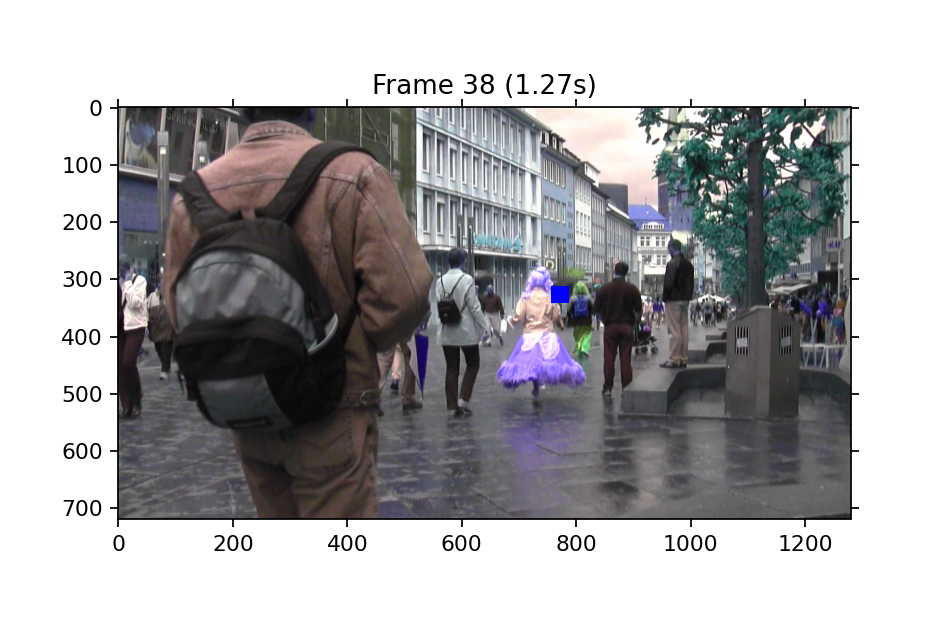

KeyboardInterrupt: 

In [168]:
%matplotlib notebook
VIDEO = 'breite_strasse'
OBSERVER = 'ALK'

video_path = f'data/GazeCom/movies_mpg/{VIDEO}.mpg'
label_path = f'data/GazeCom/movies_mpg_frames/train/label_data/{VIDEO}/{OBSERVER}_{VIDEO}.txt'
dir_arff_ground_truth = r'data/GazeCom/deepEM_classifier/ground_truth'
raw_label_path = f'{dir_arff_ground_truth}/{VIDEO}/{OBSERVER}_{VIDEO}.arff'

utils.plot_gazecom_frames_with_labels(video_path, label_path, raw_label_path)
%matplotlib inline

**Calculate visual angle**

In [17]:
arr_new = px_to_visual_angle(arr, 'x', 'y', width_px, height_px, width_mm, height_mm, distance_mm)
arr_new.shape, arr_new.dtype

((5008,),
 dtype([('time', '<f8'), ('x', '<f8'), ('y', '<f8'), ('confidence', '<f8'), ('handlabeller1', '<f8'), ('handlabeller2', '<f8'), ('handlabeller_final', '<f8'), ('x_angle', '<f8'), ('y_angle', '<f8')]))

In [18]:
arr_new['x_angle']

array([-0.03408402, -0.03408402, -0.03429211, ...,  0.04628636,
        0.04691   ,  0.04718717])

#### Create annotations.txt

In [17]:
width_px    = 1280.0
height_px   = 720.0
width_mm    = 400.0
height_mm   = 225.0
distance_mm = 450.0

In [18]:
'''
jumping/0001 17 0
jumping/0002 18 0
running/0001 15 1
running/0002 15 1

dirname <frame> EM gaze_x gaze_y

'''

'\njumping/0001 17 0\njumping/0002 18 0\nrunning/0001 15 1\nrunning/0002 15 1\n\ndirname <frame> EM gaze_x gaze_y\n\n'

In [46]:
dir_arff_ground_truth

'data/GazeCom/deepEM_classifier/ground_truth'

In [48]:
# GazeCom
dir_arff_ground_truth = r'data/GazeCom/deepEM_classifier/ground_truth'
frames_dir = r'data\GazeCom\movies_mpg_frames\train\video_data'

structured_dt = np.dtype([('video', '<U30'), ('frame', '<f8'), ('label', '<f8'), ('x_angle', '<f8'), ('y_angle', '<f8')])

#labels_video = None
for dirname in tqdm(os.listdir(dir_arff_ground_truth)): # video folders
    #labels_video = np.empty((0, 5), dtype=structured_dt)
    
    _, _, files = next(os.walk(os.path.join(frames_dir, dirname)))
    n_frames = len(files)
    print(dirname, n_frames)
    
    for file in tqdm(os.listdir(os.path.join(dir_arff_ground_truth, dirname))): # observer label files
        observer = file.split('_')[0]
        
        # load eye-tracking data
        arr = loadarff(os.path.join(dir_arff_ground_truth, dirname, file))[0]
        
        # Averages eye tracking results over frames
        avg_arr, missing_frames = avg_over_frames(arr, 'time', 'x', 'y', 'handlabeller_final', n_frames=n_frames)
        if missing_frames:
            logger.warning(f"The following {len(missing_frames)} frames don't have a label in '{file}':{missing_frames}.")
        
        # Group NOISE and UNKNOWN classifications
        avg_arr[avg_arr[:, 1] == 4, 1] = 0
        
        # Add video directory-path
        paths   = np.full(avg_arr.shape[0], dirname, dtype='<U30')
        struct_avg_arr = np.array(rfn.unstructured_to_structured(np.c_[ paths, avg_arr ]), dtype=structured_dt) 
        
        # Create export_dir if not existant
        write_path = os.path.join(frames_dir, 'labels', dirname)
        Path(write_path).mkdir(parents=True, exist_ok=True)
        
        np.savetxt(os.path.join(write_path, f'{observer}_{dirname}.txt'), struct_avg_arr, fmt=['%s', '%d', '%d', '%d', '%d'])
        
        #if labels_video is None:
        #    labels_video = struct_avg_arr.copy()
        #else:
        #    labels_video = np.concatenate([labels_video, struct_avg_arr])
        
    # write annotations.txt for each video
    #np.savetxt(os.path.join(frames_dir, f'{dirname}_annotations.txt'), labels_video, fmt=['%s', '%d', '%d', '%d', '%d'])

# write global annotations.txt
#np.savetxt(os.path.join(frames_dir, f'annotations.txt'), labels_video, fmt=['%s', '%d', '%d', '%d', '%d'])    

  0%|          | 0/18 [00:00<?, ?it/s]

beach 597


  0%|          | 0/47 [00:00<?, ?it/s]

breite_strasse 597


  0%|          | 0/52 [00:00<?, ?it/s]

bridge_1 599


  0%|          | 0/50 [00:00<?, ?it/s]

bridge_2 599


  0%|          | 0/52 [00:00<?, ?it/s]

bumblebee 251


  0%|          | 0/43 [00:00<?, ?it/s]

doves 597


  0%|          | 0/46 [00:00<?, ?it/s]

ducks_boat 597


  0%|          | 0/46 [00:00<?, ?it/s]

ducks_children 598


  0%|          | 0/50 [00:00<?, ?it/s]

golf 597


  0%|          | 0/45 [00:00<?, ?it/s]

holsten_gate 597


  0%|          | 0/46 [00:00<?, ?it/s]

koenigstrasse 570


  0%|          | 0/49 [00:00<?, ?it/s]

puppies 597


  0%|          | 0/46 [00:00<?, ?it/s]

roundabout 597


  0%|          | 0/49 [00:00<?, ?it/s]

sea 597


  0%|          | 0/37 [00:00<?, ?it/s]

street 597


  0%|          | 0/50 [00:00<?, ?it/s]

st_petri_gate 597


  0%|          | 0/50 [00:00<?, ?it/s]

st_petri_market 597


  0%|          | 0/45 [00:00<?, ?it/s]

st_petri_mcdonalds 597


  0%|          | 0/41 [00:00<?, ?it/s]

<br>
<br>

## Vidcom <a id='vidcom' />

<br>
<br>

## DHF1K <a id='dhf1k' />

In [15]:
dir_dfh1k_label = r'data/DHF1K/annotation'

##### test load a .mat file

In [16]:
sample_path = f'{dir_dfh1k_label}/0001/fixation/maps/0001.mat'

In [17]:
contents = loadmat(sample_path)
contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Oct 14 22:08:46 2017',
 '__version__': '1.0',
 '__globals__': [],
 'I': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [18]:
arr = contents['I']
print(arr.shape)
arr

(360, 640)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [19]:
print(arr[arr!=0].sum(), arr[arr!=0])

358 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


<br>
<br>

## Hollywood-2 <a id='hollywood' />

<br>
<br>

# Working with Video Data<a id='video-data' />

In [3]:
folder = r'data/GazeCom/movies_mpg'

vidcap = cv2.VideoCapture(f'{folder}/beach.mpg')
success,image = vidcap.read()
frame = 0
while success:
    print(image.shape, image)
    break
    if count % 10 == 0:
        plt.imshow(image)
        plt.title(f'Frame {frame}')
        plt.show()
        plt.pause(1)
    success,image = vidcap.read()
    #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file 
    frame += 1

(720, 1280, 3) [[[138 113 119]
  [248 223 229]
  [205 173 179]
  ...
  [213 177 174]
  [199 163 160]
  [255 239 236]]

 [[178 153 159]
  [255 255 255]
  [220 188 194]
  ...
  [233 197 194]
  [212 176 173]
  [255 255 255]]

 [[158 140 145]
  [255 249 254]
  [193 169 173]
  ...
  [207 180 178]
  [177 150 148]
  [255 255 255]]

 ...

 [[104 103 113]
  [224 223 233]
  [141 138 155]
  ...
  [ 80  70  72]
  [ 55  45  47]
  [138 128 130]]

 [[128 130 132]
  [235 237 239]
  [140 139 149]
  ...
  [ 80  70  72]
  [ 55  45  47]
  [138 128 130]]

 [[140 142 144]
  [240 242 244]
  [143 142 152]
  ...
  [ 80  70  72]
  [ 55  45  47]
  [138 128 130]]]


### Save video frames as individual images

In [35]:
def store_frames_to_jpg(video_path, export_dir):
    # Create export_dir if not existant
    Path(export_dir).mkdir(parents=True, exist_ok=True)
    
    # Open video
    vidcap = cv2.VideoCapture(video_path)
    
    success, image = vidcap.read()
    frame = 1
    
    while success:
        # save frame as JPEG file 
        cv2.imwrite(os.path.join(export_dir, f"frame_{frame:05d}.jpg"), image)
        
        success, image = vidcap.read()
        frame += 1

In [36]:
# GazeCom
input_dir = r'data/GazeCom/movies_mpg'
output_dir = r'data/GazeCom/movies_mpg_frames'

f = []
for (dirpath, dirnames, filenames) in os.walk(input_dir):
    for file in tqdm(filenames):
        filename, _ = os.path.splitext(file)
        video_path = os.path.join(dirpath, file)
        export_dir = os.path.join(output_dir, filename.replace(".", "_"))
        
        store_frames_to_jpg(video_path, export_dir)
    break

  0%|          | 0/18 [00:00<?, ?it/s]

<br>
<br>

# Prepare labeling data <a id='label-data' />